# Delta-Hedged Options Strategy Backtest

This notebook contains a complete, self-contained backtest of a delta-hedging strategy. It includes all necessary components:

1.  **Setup**: Installs required libraries.
2.  **Strategy Logic**: The `NewDeltaHedgeStrategy` class.
3.  **Execution & Analysis**: Runs the backtest and displays the results.

## 1. Setup & Configuration

In [2]:
import os
import pandas as pd
import numpy as np
from typing import List, Dict, Any, Tuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

# --- Configuration ---
# You can set your real token here if you replace the mock data source
# os.environ['OPLAB_ACCESS_TOKEN'] = '' 

from opstrat_backtester.core.strategy import Strategy
from opstrat_backtester.core.engine import Backtester
from opstrat_backtester.analytics.plots import plot_pnl
from opstrat_backtester.data_loader import OplabDataSource


## 2. Trading Strategy Definition

In [6]:
class NewDeltaHedgeStrategy(Strategy):
    def __init__(self, spot_symbol: str, initial_dte: int = 60, exit_dte: int = 30):
        super().__init__()
        self.spot_symbol = spot_symbol
        self.initial_dte = initial_dte
        self.exit_dte = exit_dte

    def generate_signals(
        self,
        date: pd.Timestamp,
        daily_options_data: pd.DataFrame,
        stock_history: pd.DataFrame,
        portfolio
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:

        signals = []
        custom_indicators = {}
        positions = portfolio.get_positions()
        has_option_position = any(ticker != self.spot_symbol for ticker in positions)

        if has_option_position:
            for ticker, pos in positions.items():
                if ticker == self.spot_symbol:
                    continue

                option_data = daily_options_data[daily_options_data['symbol'] == ticker]
                if not option_data.empty:
                    current_dte = option_data['days_to_maturity'].iloc[0]
                    if current_dte <= self.exit_dte:
                        signals.append({'ticker': ticker, 'quantity': -pos['quantity']})
                        if self.spot_symbol in positions:
                            signals.append({
                                'ticker': self.spot_symbol, 
                                'quantity': -positions[self.spot_symbol]['quantity']
                            })
                        break 

        elif not has_option_position:
            valid_options = daily_options_data[
                (daily_options_data['type'] == 'CALL') &
                (daily_options_data['days_to_maturity'].between(self.initial_dte - 7, self.initial_dte + 7))
            ]
            
            if not valid_options.empty:
                target_call = valid_options.iloc[(valid_options['delta'] - 0.5).abs().argsort()[:1]]
                
                if not target_call.empty:
                    target_call = target_call.iloc[0]
                    option_quantity = 1
                    signals.append({'ticker': target_call['symbol'], 'quantity': option_quantity})
                    
                    hedge_quantity = int(option_quantity * 100 * target_call['delta'])
                    signals.append({'ticker': self.spot_symbol, 'quantity': -hedge_quantity})
                    custom_indicators['entry_option_delta'] = target_call['delta']

        return signals, custom_indicators

## 3. Execution and Analysis

In [ ]:
# --- Main Execution Block ---

SPOT_SYMBOL = "BOVA11"
START_DATE = "2023-01-01"
END_DATE = "2024-03-31"
INITIAL_CASH = 100_000.00

# 1. Instantiate the Data Source
oplab_data_source = OplabDataSource()

# 2. Instantiate the Strategy
my_strategy = NewDeltaHedgeStrategy(spot_symbol=SPOT_SYMBOL, initial_dte=60, exit_dte=30)

# 3. Instantiate the Backtester
backtester = Backtester(
    strategy=my_strategy,
    start_date=START_DATE,
    end_date=END_DATE,
    spot_symbol=SPOT_SYMBOL,
    initial_cash=INITIAL_CASH,
)
backtester.set_data_source(oplab_data_source)

# 4. Run the Backtest
daily_summary_df, trades_df = backtester.run()

print("\n--- Backtest Complete ---")

Starting backtest...
Streaming stock data for BOVA11 from 2023-01-01 00:00:00+00:00 to 2024-03-31 00:00:00+00:00
Processing stock data for year 2023...
Cache miss for stock data stock/BOVA11/2023. Fetching from API...
Cache miss for stock data stock/BOVA11/2023. Fetching from API...
Processing stock data for year 2024...
Cache miss for stock data stock/BOVA11/2024. Fetching from API...
Cache miss for stock data stock/BOVA11/2024. Fetching from API...


/workspaces/optstrat_bt/src/opstrat_backtester/data_loader.py:37: UserWarning: Converting to Period representation will drop timezone information.
  months_to_process = pd.date_range(start=start.to_period('M').start_time.tz_localize('UTC'), end=end, freq='MS')


Streaming data for BOVA11 from 2023-01-01 00:00:00+00:00 to 2024-03-31 00:00:00+00:00


Processing Data Months:   0%|          | 0/15 [00:00<?, ?it/s]

Processing chunk: 2023-01-02 to 2023-01-31


Processing Data Months:   7%|▋         | 1/15 [00:00<00:01,  8.96it/s]

Processing chunk: 2023-02-01 to 2023-02-28


Processing Data Months:  13%|█▎        | 2/15 [00:00<00:01,  8.55it/s]

Processing chunk: 2023-03-01 to 2023-03-31


Processing Data Months:  20%|██        | 3/15 [00:00<00:01,  7.65it/s]

Processing chunk: 2023-04-03 to 2023-04-28


Processing Data Months:  27%|██▋       | 4/15 [00:00<00:01,  7.75it/s]

Processing chunk: 2023-05-02 to 2023-05-31


Processing Data Months:  33%|███▎      | 5/15 [00:00<00:01,  7.92it/s]

Processing chunk: 2023-06-02 to 2023-06-30


Processing Data Months:  40%|████      | 6/15 [00:00<00:01,  8.25it/s]

Processing chunk: 2023-07-03 to 2023-07-31


Processing Data Months:  47%|████▋     | 7/15 [00:00<00:00,  8.29it/s]

Processing chunk: 2023-08-01 to 2023-08-31


Processing Data Months:  53%|█████▎    | 8/15 [00:01<00:00,  7.49it/s]

Processing chunk: 2023-09-01 to 2023-09-29


Processing Data Months:  60%|██████    | 9/15 [00:01<00:00,  7.84it/s]

Processing chunk: 2023-10-02 to 2023-10-31


Processing Data Months:  67%|██████▋   | 10/15 [00:01<00:00,  7.67it/s]

Processing chunk: 2023-11-01 to 2023-11-30


Processing Data Months:  73%|███████▎  | 11/15 [00:01<00:00,  7.99it/s]

Processing chunk: 2023-12-01 to 2023-12-28


Processing Data Months:  80%|████████  | 12/15 [00:01<00:00,  7.74it/s]

Processing chunk: 2024-01-02 to 2024-01-31


Processing Data Months:  87%|████████▋ | 13/15 [00:01<00:00,  6.98it/s]

Processing chunk: 2024-02-01 to 2024-02-29


Processing Data Months:  93%|█████████▎| 14/15 [00:01<00:00,  7.31it/s]

Processing chunk: 2024-03-01 to 2024-03-28


Processing Data Months: 100%|██████████| 15/15 [00:01<00:00,  7.66it/s]


--- Backtest Complete ---


In [1]:
print("\n--- Daily Portfolio Summary (last 10 days) ---")
daily_summary_df


--- Daily Portfolio Summary (last 10 days) ---


NameError: name 'daily_summary_df' is not defined

In [14]:
print("\n\n--- Detailed Trade Log ---")
# Set display options to see all columns of the detailed log
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
display(trades_df)



--- Detailed Trade Log ---


,decision_date,execution_date,ticker,signal_quantity,decision_symbol,decision_time,decision_spot,decision_type,decision_due_date,decision_strike,decision_premium,decision_maturity_type,decision_days_to_maturity,decision_moneyness,decision_delta,decision_gamma,decision_vega,decision_theta,decision_rho,decision_volatility,decision_poe,decision_bs,decision_open,decision_high,decision_low,decision_close,decision_volume,decision_financial_volume,decision_ewma_current,decision_parent_symbol,decision_spot_price,decision_category,decision_due_date_detail,decision_days_to_maturity_detail,decision_strike_detail,decision_premium_detail,decision_maturity_type_detail,trade_status,execution_price,execution_symbol,execution_time,execution_spot,execution_type,execution_due_date,execution_strike,execution_premium,execution_maturity_type,execution_days_to_maturity,execution_moneyness,execution_delta,execution_gamma,execution_vega,execution_theta,execution_rho,execution_volatility,execution_poe,execution_bs,execution_open,execution_high,execution_low,execution_close,execution_volume,execution_financial_volume,execution_ewma_current,execution_parent_symbol,execution_spot_price,execution_category,execution_due_date_detail,execution_days_to_maturity_detail,execution_strike_detail,execution_premium_detail,execution_maturity_type_detail,entry_option_delta
0,2023-01-02 00:00:00+00:00,2023-01-03 00:00:00+00:00,BOVAC82,1,BOVAC82,2023-01-02 00:00:00+00:00,"{'price': 102.63, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,3.20,AMERICAN,53.0,OTM,0.476995,0.043742,0.187456,-0.037843,0.096228,19.345,44.18,3.2000,5.50,5.50,3.20,3.20,552.0,1770.70,NaN,BOVA11,102.63,CALL,2023-03-17T00:00:00.000Z,53.0,104.0,3.20,AMERICAN,EXECUTED,5.10,BOVAC82,2023-01-03 00:00:00+00:00,"{'price': 100.48, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,5.04,AMERICAN,53.0,OTM,0.455983,0.024815,0.182714,-0.063007,0.085761,34.676,39.37,5.0401,5.10,5.10,4.43,5.04,565.0,2856.76,NaN,BOVA11,100.48,CALL,2023-03-17T00:00:00.000Z,53.0,104.0,5.04,AMERICAN,0.476995
1,2023-01-02 00:00:00+00:00,2023-01-03 00:00:00+00:00,BOVA11,-47,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FAILED_NO_DATA,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.476995
2,2023-02-03 00:00:00+00:00,2023-02-06 00:00:00+00:00,BOVAC82,-1,BOVAC82,2023-02-03 00:00:00+00:00,"{'price': 104.87, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,4.60,AMERICAN,30.0,ATM,0.563249,0.038901,0.142534,-0.070803,0.064843,27.985,52.50,4.5999,4.95,5.70,4.12,4.60,67865.0,334650.03,NaN,BOVA11,104.87,CALL,2023-03-17T00:00:00.000Z,30.0,104.0,4.60,AMERICAN,EXECUTED,3.86,BOVAC82,2023-02-06 00:00:00+00:00,"{'price': 105.25, 'symbol': 'BOVA11'}",CALL,2023-03-17T00:00:00.000Z,104.0,4.43,AMERICAN,28.0,ITM,0.581549,0.042471,0.137028,-0.068647,0.063087,26.213,54.72,4.4300,4.02,4.45,3.86,4.43,315189.0,1290013.71,NaN,BOVA11,105.25,CALL,2023-03-17T00:00:00.000Z,28.0,104.0,4.43,AMERICAN,NaN
3,2023-02-15 00:00:00+00:00,2023-02-16 00:00:00+00:00,BOVAE108,1,BOVAE108,2023-02-15 00:00:00+00:00,"{'price': 106.05, 'symbol': 'BOVA11'}",CALL,2023-05-19T00:00:00.000Z,108.0,4.95,AMERICAN,67.0,OTM,0.487278,0.028509,0.218040,-0.045327,0.124231,25.577,43.50,4.9500,3.31,5.35,3.31,4.95,88062.0,430507.25,NaN,BOVA11,106.05,CALL,2023-05-19T00:00:00.000Z,67.0,108.0,4.95,AMERICAN,EXECUTED,5.44,BOVAE108,2023-02-16 00:00:00+00:00,"{'price': 106.5, 'symbol': 'BOVA11'}",CALL,2023-05-19T00:00:00.000Z,108.0,5.08,AMERICAN,66.0,OTM,0.499006,0.028858,0.217435,-0.045595,0.125882,25.364,44.74,5.0801,4.95,5.44,4.26,5.08,43055.0,212162.44,NaN,BOVA11,106.50,CALL,2023-05-19T00:00:00.000Z,66.0,108.0,5.08,AMERICAN,0.487278
4,2023-02-15 00:00:00+00:00,2023-02-16 00:00:00+00:00,BOVA11,-48,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

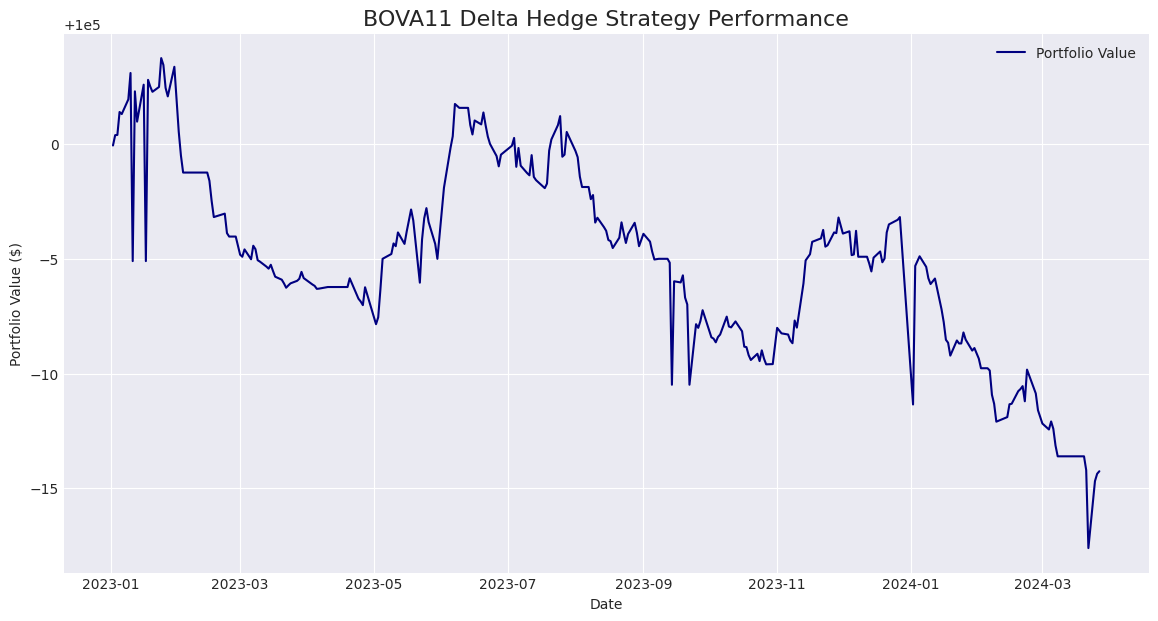

In [15]:
def plot_pnl(daily_summary: pd.DataFrame, title: str):
    """Plots the portfolio value over time."""
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Ensure the date column is a datetime object for plotting
    daily_summary['date'] = pd.to_datetime(daily_summary['date'])
    
    ax.plot(daily_summary['date'], daily_summary['portfolio_value'], label='Portfolio Value', color='navy')
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value ($)')
    ax.legend()
    plt.grid(True)
    plt.show()

plot_pnl(daily_summary_df, title=f"{SPOT_SYMBOL} Delta Hedge Strategy Performance")